# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


### Change classifiers into binary

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68817 entries, 0 to 68816
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   68817 non-null  float64
 1   int_rate                    68817 non-null  float64
 2   installment                 68817 non-null  float64
 3   home_ownership              68817 non-null  object 
 4   annual_inc                  68817 non-null  float64
 5   verification_status         68817 non-null  object 
 6   issue_d                     68817 non-null  object 
 7   loan_status                 68817 non-null  object 
 8   pymnt_plan                  68817 non-null  object 
 9   dti                         68817 non-null  float64
 10  delinq_2yrs                 68817 non-null  float64
 11  inq_last_6mths              68817 non-null  float64
 12  open_acc                    68817 non-null  float64
 13  pub_rec                     688

## Split the Data into Training and Testing

In [6]:
# Create our features
X = df.drop(columns='loan_status')
# Create our target
y=df.loan_status

In [7]:
X_exp = pd.get_dummies(X, columns=['home_ownership', 
                                       'verification_status', 
                                       'issue_d', 
                                       'pymnt_plan', 
                                       'initial_list_status', 
                                       'next_pymnt_d', 
                                       'application_type', 
                                       'hardship_flag', 
                                       'debt_settlement_flag'
                                      ])

In [8]:
print(f'Number of records in original DataFrame = {df.shape[1]}')
print(f'Number of records in expanded DataFrame = {X_exp.shape[1]}')

Number of records in original DataFrame = 86
Number of records in expanded DataFrame = 95


In [9]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [10]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [11]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_exp, y, random_state=1)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [12]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [14]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [15]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
rf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
rf_model = rf_model.fit(X_train_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

In [16]:
# Calculated the balanced accuracy score
acc_score = accuracy_score(y_test, predictions)
acc_score

0.8735251380412671

In [17]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
cm_df

,Predicted 0,Predicted 1
Actual 0,71,30
Actual 1,2146,14958


In [18]:
# Print the imbalanced classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

   high_risk       0.03      0.70      0.06       101
    low_risk       1.00      0.87      0.93     17104

    accuracy                           0.87     17205
   macro avg       0.52      0.79      0.50     17205
weighted avg       0.99      0.87      0.93     17205



<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

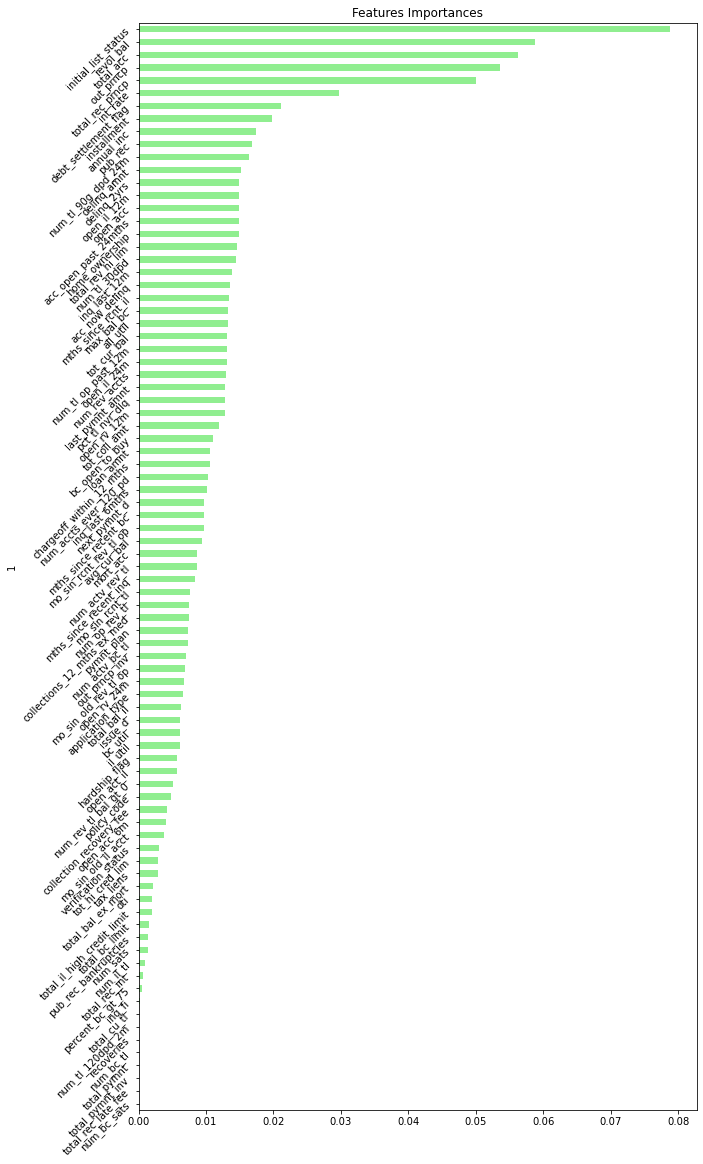

In [19]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances',rot=45,figsize=(10,20), legend=False)


### Easy Ensemble Classifier

In [20]:
# Train the Classifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100,random_state=1)
eec = eec.fit(X_train_scaled, y_train)
predictions_EEC = eec.predict(X_test_scaled)

In [21]:
# Calculated the balanced accuracy score
bacc_score = accuracy_score(y_test, predictions_EEC)
bacc_score

0.9422842197035746

In [22]:
# Display the confusion matrix
cm2 = confusion_matrix(y_test, predictions_EEC)
cm_df2 = pd.DataFrame(
    cm2, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
cm_df2

,Predicted 0,Predicted 1
Actual 0,93,8
Actual 1,985,16119


In [23]:
# Print the imbalanced classification report
print(classification_report(y_test, predictions_EEC))

              precision    recall  f1-score   support

   high_risk       0.09      0.92      0.16       101
    low_risk       1.00      0.94      0.97     17104

    accuracy                           0.94     17205
   macro avg       0.54      0.93      0.56     17205
weighted avg       0.99      0.94      0.97     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    The easy essembler method had the best ACC score with .942

2. Which model had the best recall score?

    Once again the easy ensembler method takes it with a average .93 recall percentage.

3. Which model had the best geometric mean score?

    Easy esemble method takes it here but it was close.

4. What are the top three features?

    1. Initial list status 2. Revol balance. 3. Total Account Balance